# Pipeline de Dados com AWS

### Este projeto consiste em um pipeline de processamento de dados na AWS, utilizando uma arquitetura de 3 camadas (dados, lógica e aplicação) e em diferentes zonas de armazenamento (Landing, Processing, Curated) para organizar e processar dados de forma estruturada. O processamento é realizado usando um cluster no Amazon EMR com um job escrito em PySpark. O cluster Spark lê os dados brutos da Landing Zone, realiza transformações e agregações, e salva os resultados nas zonas subsequentes.


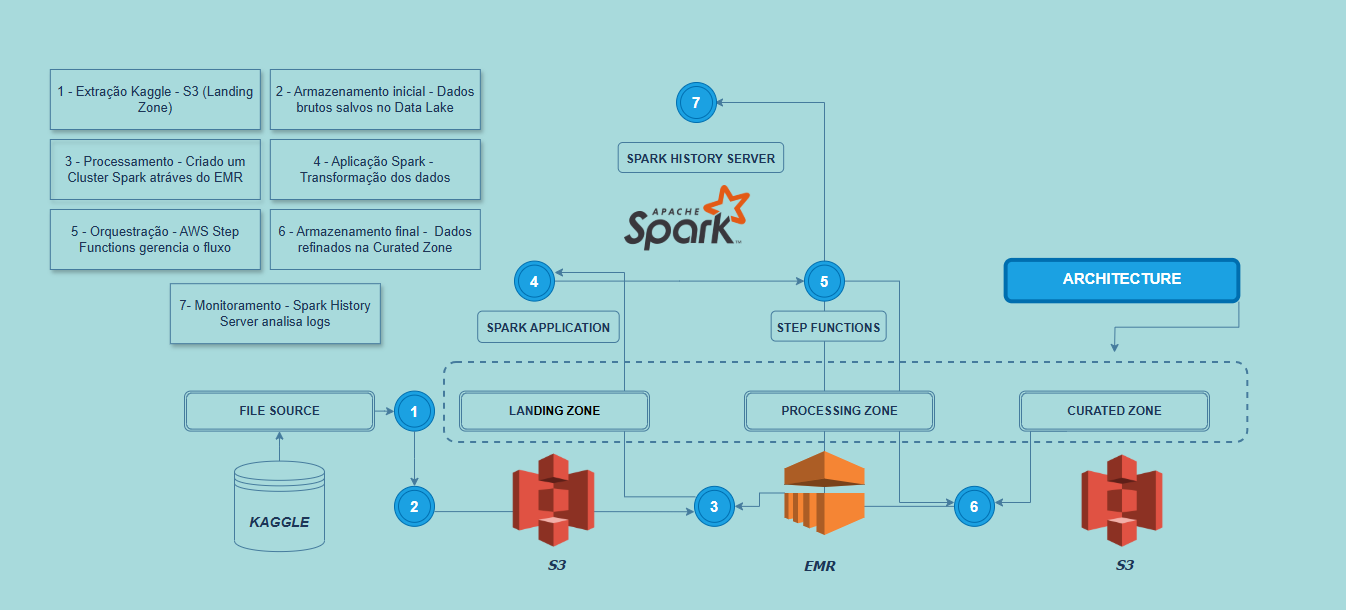


# Arquitetura

###  Usaremos a arquitetura 3 camadas (dados, lógica, aplicação) que nos dá a praticidade para utilizar as tecnologias que preferimos em cada camada, sem a necessidade de concentrar de forma monolítica.

## Landing Zone
Aqui é a camada de **dados**: a área onde faço o armazenamento dos dados raw (brutos) extraindo da minha fonte de dados. aqui geralmente não faço grandes transformações, apenas o armazenamento mesmo.


- **Características:**
Contém dados no formato original, como foram extraídos. Pode ter dados estruturados, semiestruturados (JSON, XML) ou não estruturados (imagens, vídeos, logs). Utilizada para garantir uma cópia fiel do dado original, preservando a integridade.

## Processing Zone

Essa é a camada de **Lógica**: Aqui, os dados são processados e transformados. Isso inclui limpeza, normalização, agregação ou qualquer tipo de tratamento necessário.

- **Características**: Dados começam a ser estruturados e organizados. Pode envolver processos de deduplicação, correção de erros, conversão de formatos e enriquecimento.

## Curated Zone

Camada de **Aplicação/Apresentação**: Essa é a camada onde os dados processados e organizados são armazenados de forma otimizada para serem consumidos por relatórios ou análises.

- **Características:** Dados preparados para relatórios, análises e machine learning. Estruturados em formatos prontos para consulta, como tabelas SQL ou datasets otimizados (Parquet, ORC).

# Tecnologias Utilizadas

- **AWS S3**: Armazenamento de dados nas zonas Landing, Processing e Curated.

- **Amazon EMR**: Execução do job Spark.

- **Apache Spark**: Processamento distribuído de dados.

- **PySpark**: API de Python utilizada para o job Spark.

- **Spark History Server**: Visualização do histórico de execução dos jobs Spark.

- **AWS Step Functions**: Orquestração da Pipeline

# Guia Prático do projeto

### 1° Inicio criando os buckets no Amazon S3 para o processamento dos dados

- Landing.zo
- Processing.zo
- Curated.zo

**Desmarque o bloqueio ao acesso público. Por padrão, a AWS vai perguntar se você realmente quer fazer isso por questões de segurança. Mas, como esse bucket será usado somente para esse projeto e não para um ambiente de produção, não tem problema confiar e marcar a opção**.


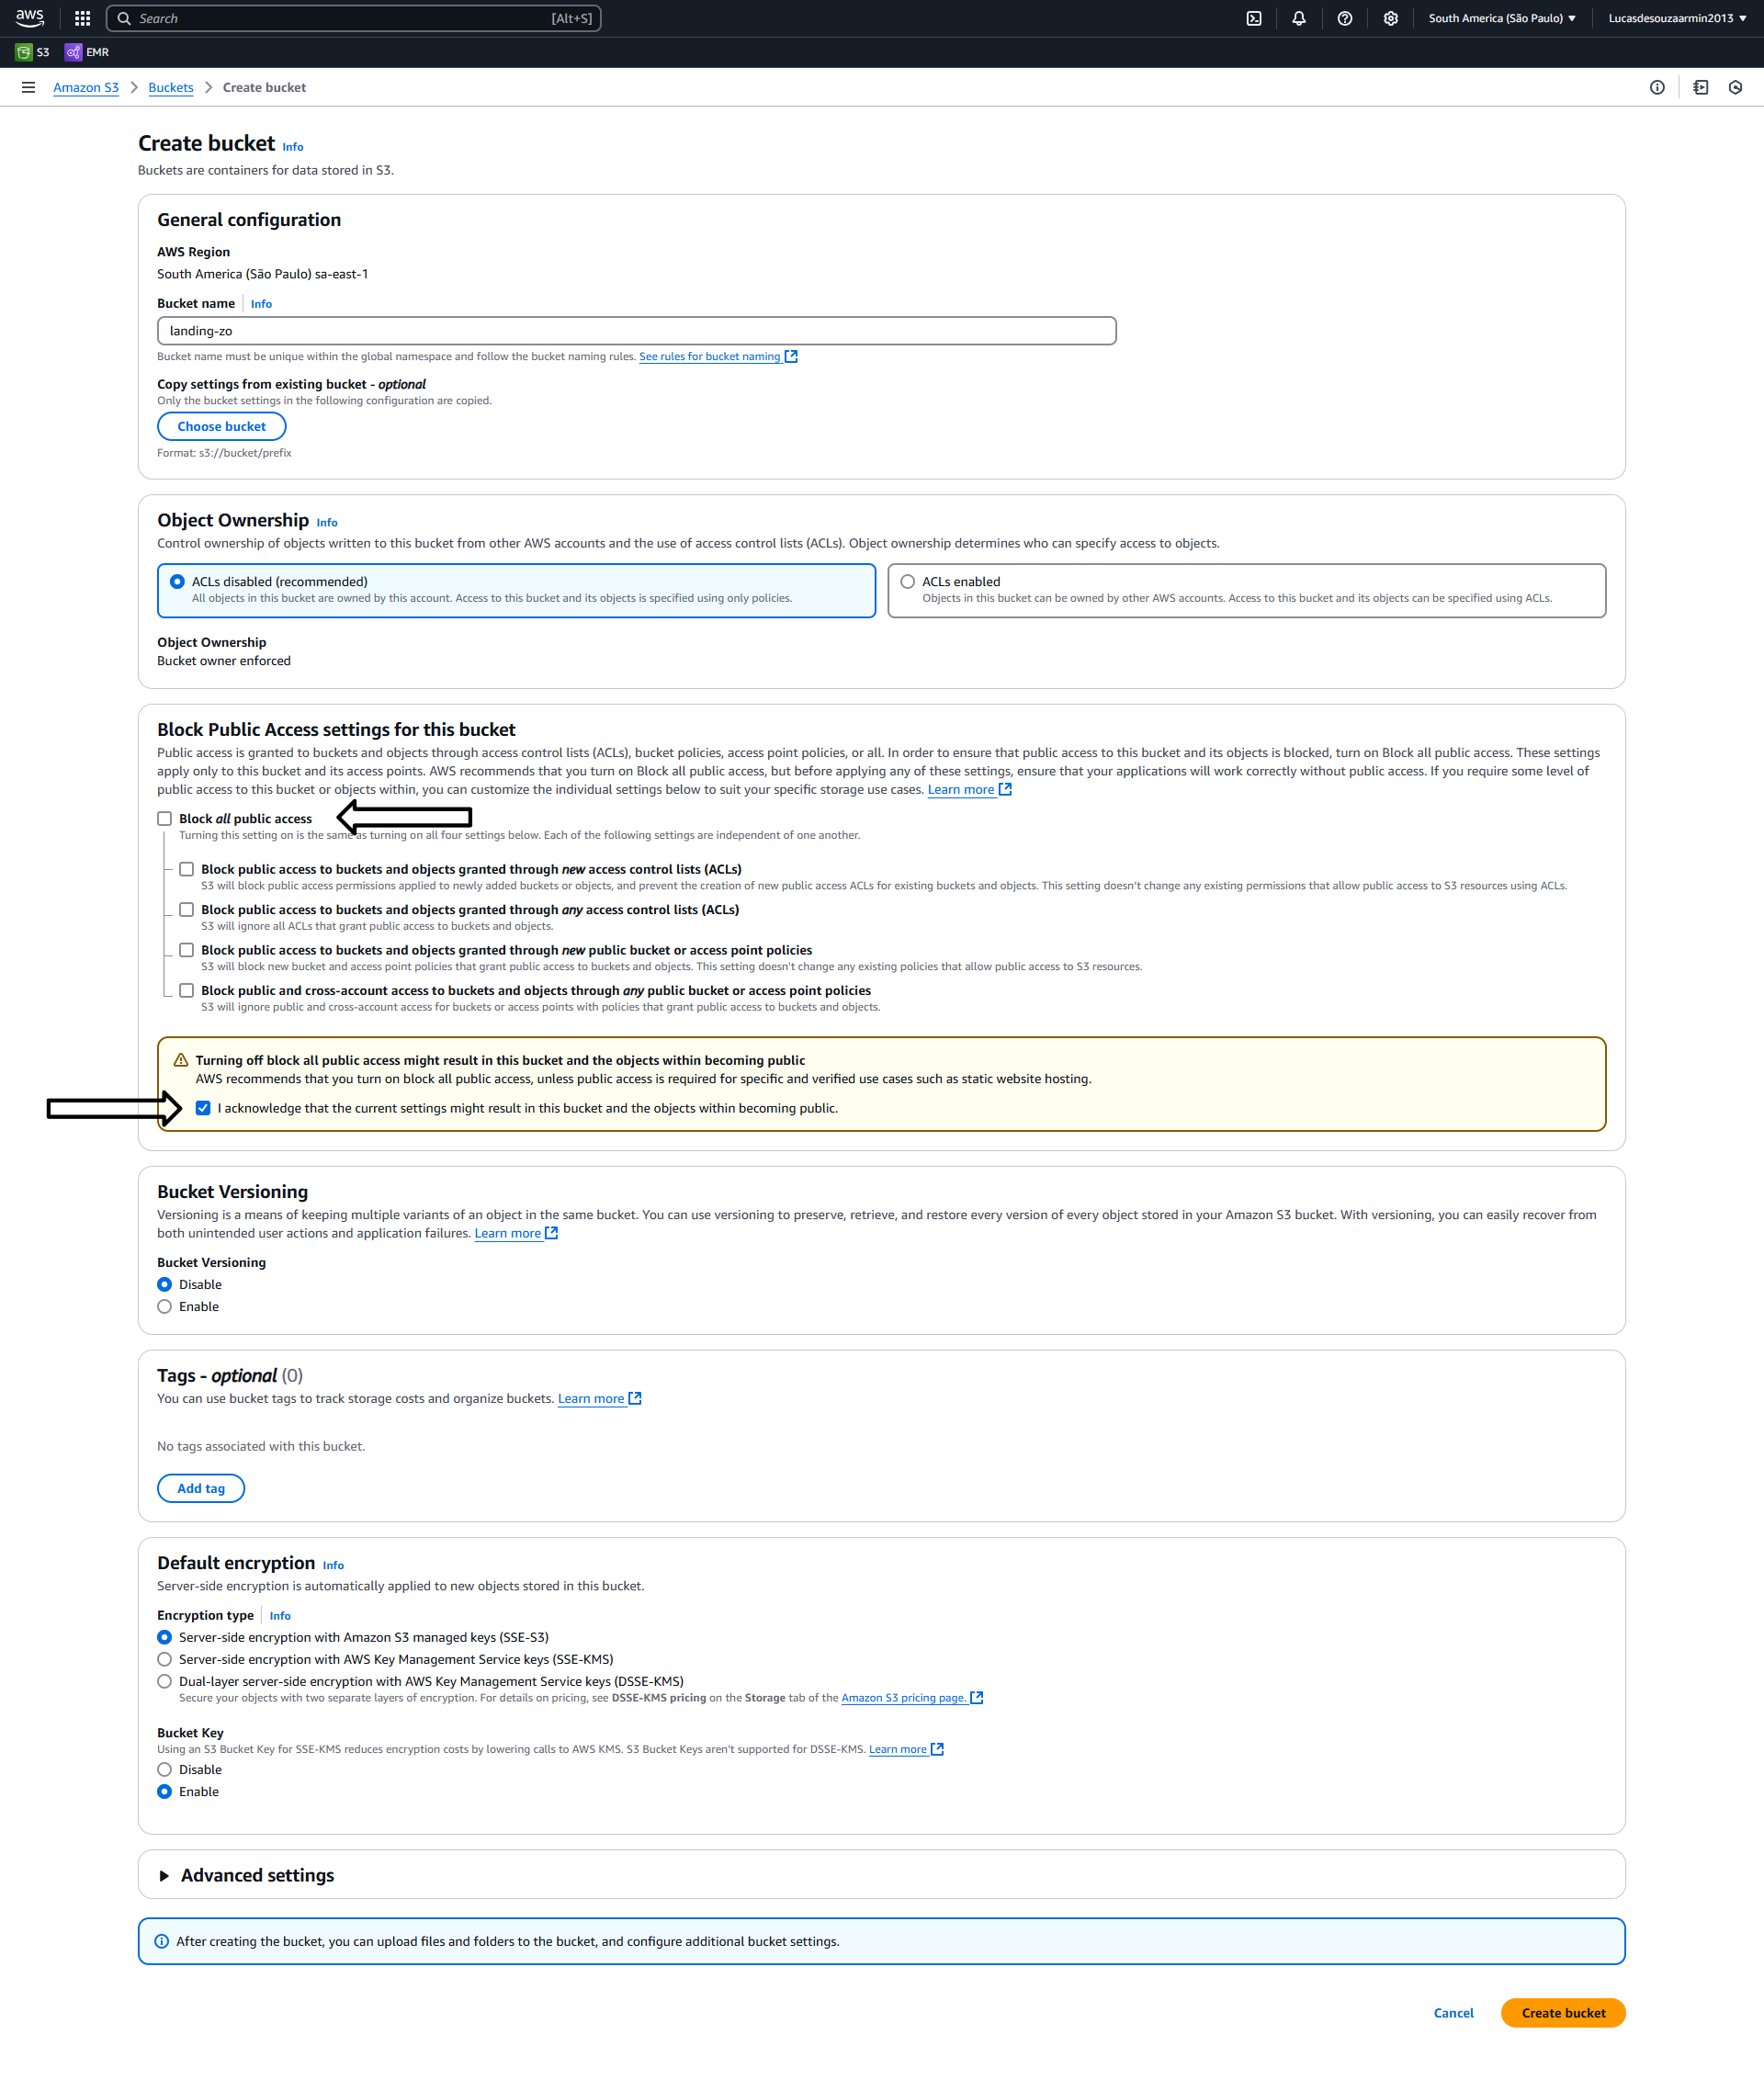

### 2° Faço o upload dos arquivos que eu já extrair da nossa fonte de dados diretamente para o bucket **Landing.zo**

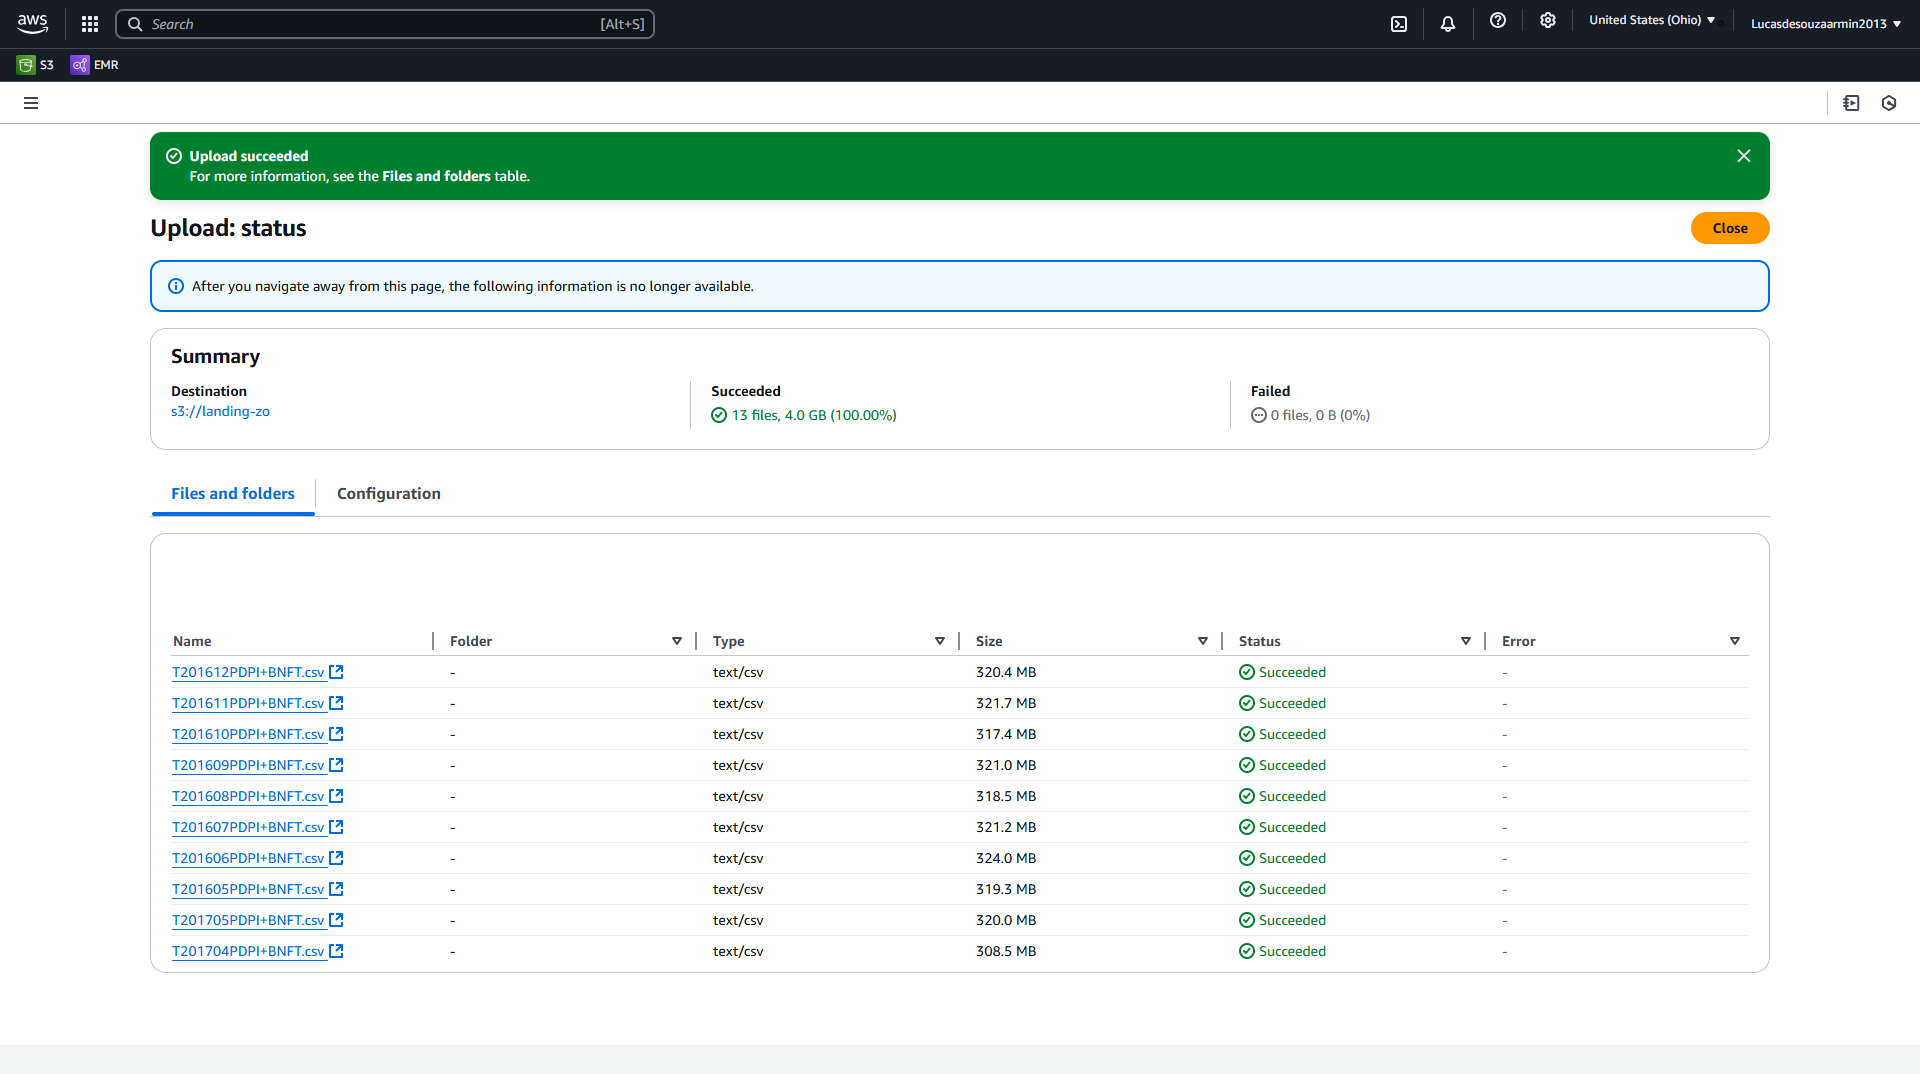

### 3° Crio um cluster no Amazon EMR
- **Name**: Coloco o nome do meu cluster 'pt-data-cluster'.
- **Amazon EMR release**:  Escolho a versão EMR 7.6 e deixo os pacotes de aplicação como default.
- **Cluster configuration**: Deixo selecionado o campo **Uniform instance** opção que oferece facilidade, estabilidade enquanto a **Flexible Instance Fleets** Permite otimizar custos e desempenho.
- **Primary**: Escolho a instância EC2 que irá atuar como nó mestre, responsável por gerenciar o cluster.
- **Core Instance**: Define os nós principais que processarão os dados. Esses nós armazenam e executam os workloads do cluster.
- **Cluster Scaling and Provisioning**: Seleciono **Set cluster size manually** que me permite definir o tamanho do cluster de forma manual, assim evitando escalonamento automático e custos inesperados.
- **Provisioning Configuration**: Defino 3 instâncias para o meu uso. Assim, aumentando minha escalabilidade, tolerância a falhas e desempenho.
- **Virtual Private Cloud**: Define a rede onde o cluster roda, controlando segurança, acesso e conectividade com outros serviços da AWS. Normalmente, já vem uma VPC padrão quando se cria uma conta na AWS, mas você pode criar uma que mais se encaixar no seu uso.
- **Security Configuration and EC2 Key Pair**: Serve para acessar as instâncias do cluster via SSH. 
- **Identity and Access Management (IAM)**: Seleciono **Create a service role** e depois, em **Security group**, coloco a vpc que eu já selecionei acima em **Networking**. E permito o acesso a todos os meus buckets.
- **EC2 instance profile for Amazon EMR**: Escolho a opção **Create an instance profile** O EMR criará automaticamente uma IAM Role nova com permissões padrão, facilitando para quem não quer configurar a Role manualmente.

### Lembrando que há diversas outras possibilidades de configurações no cluster, mas aqui coloquei somente as que eu fiz algum tipo de alteração.

- ### Após esses processo, nosso cluster está pronto para ser criado.

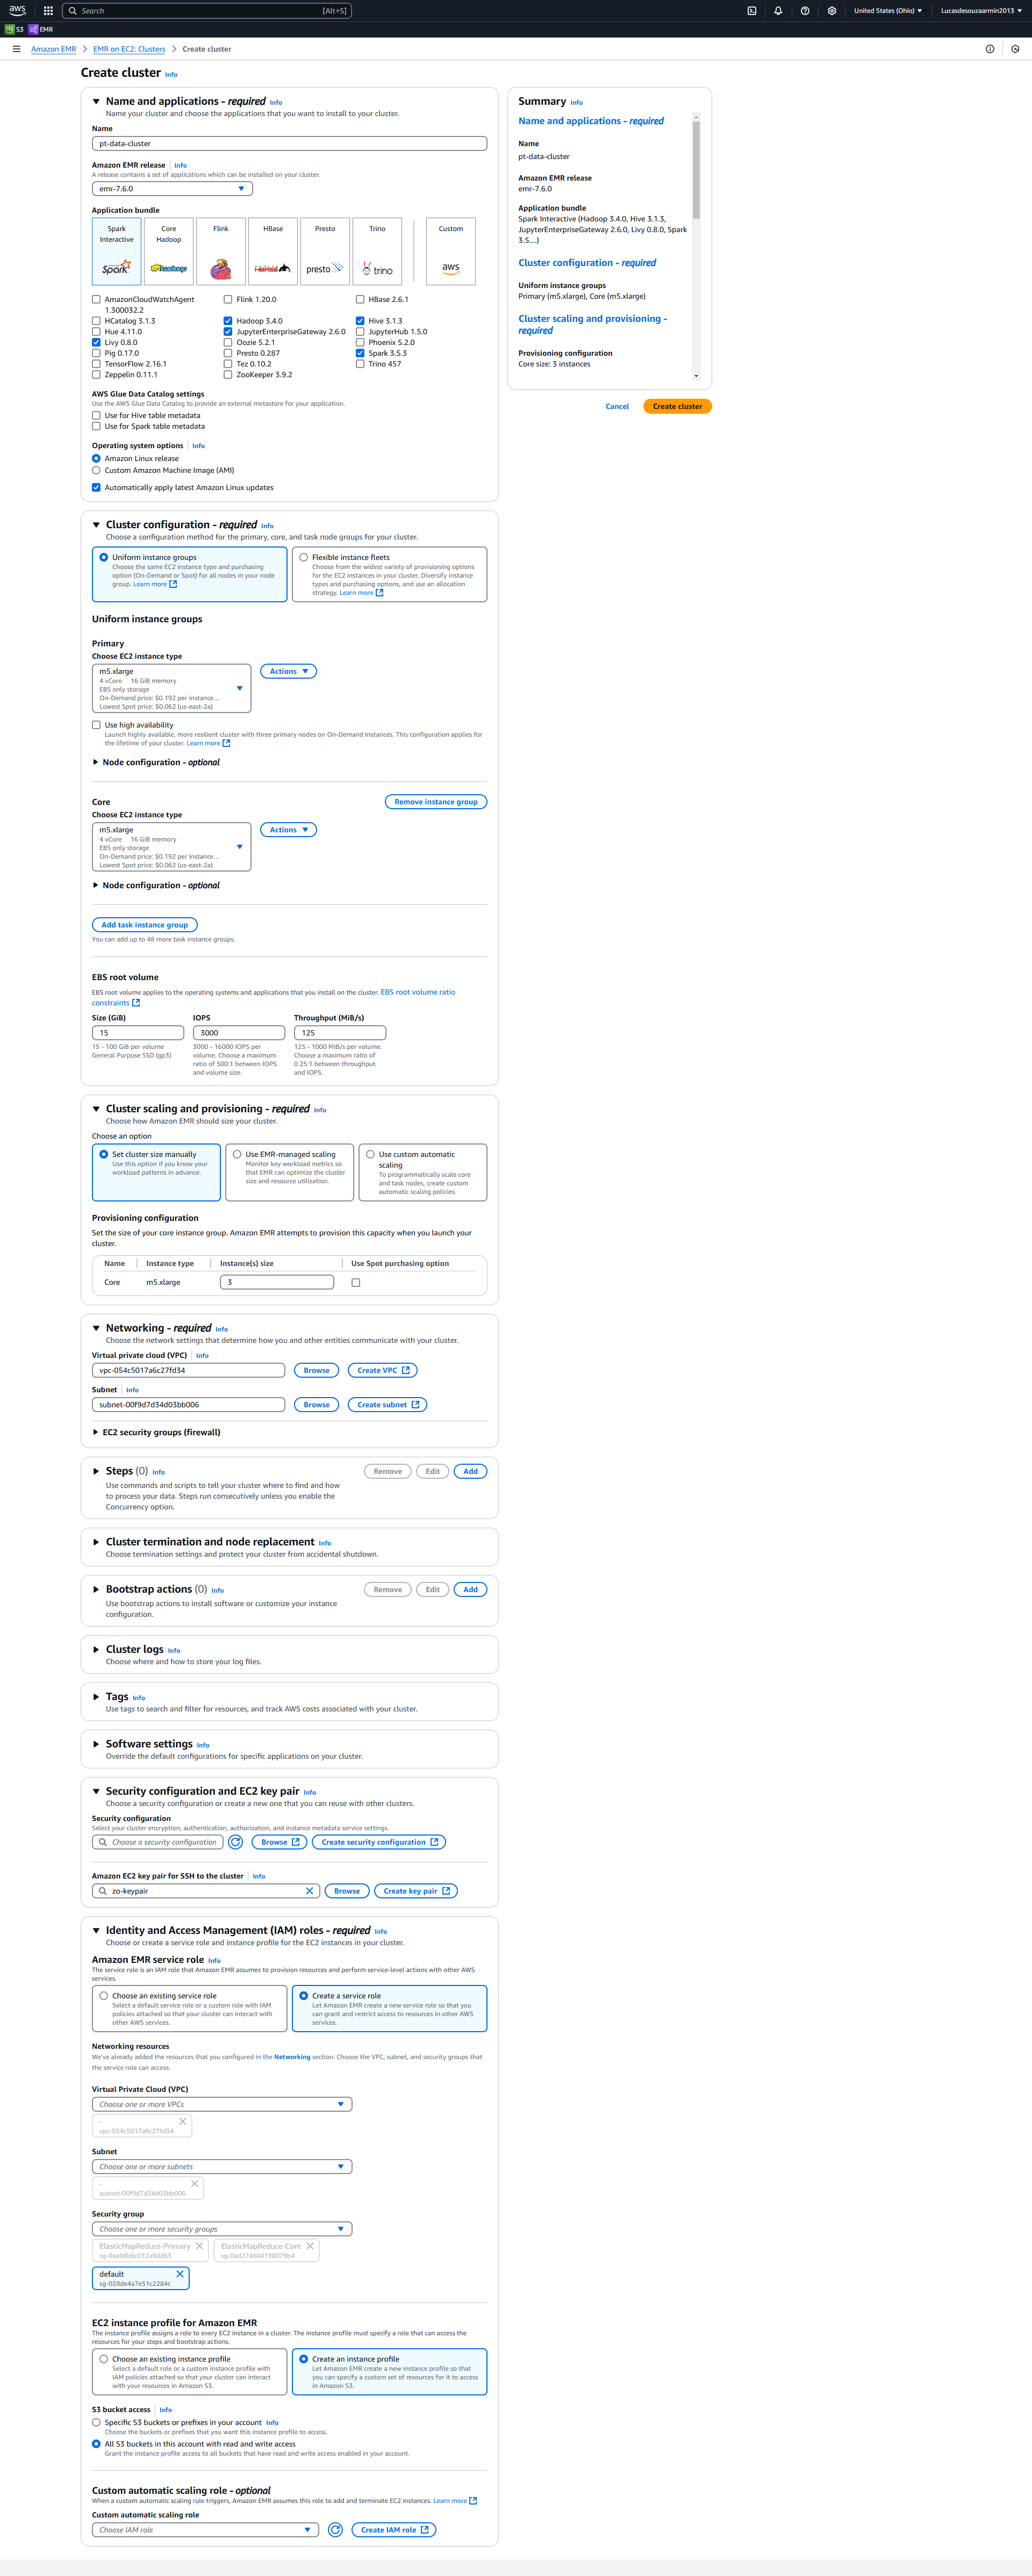

#### Aguardando o término da criação do cluster. Esperando sair do status Starting para o status Waiting, momento em que o cluster estará pronto para receber alguma tarefa.

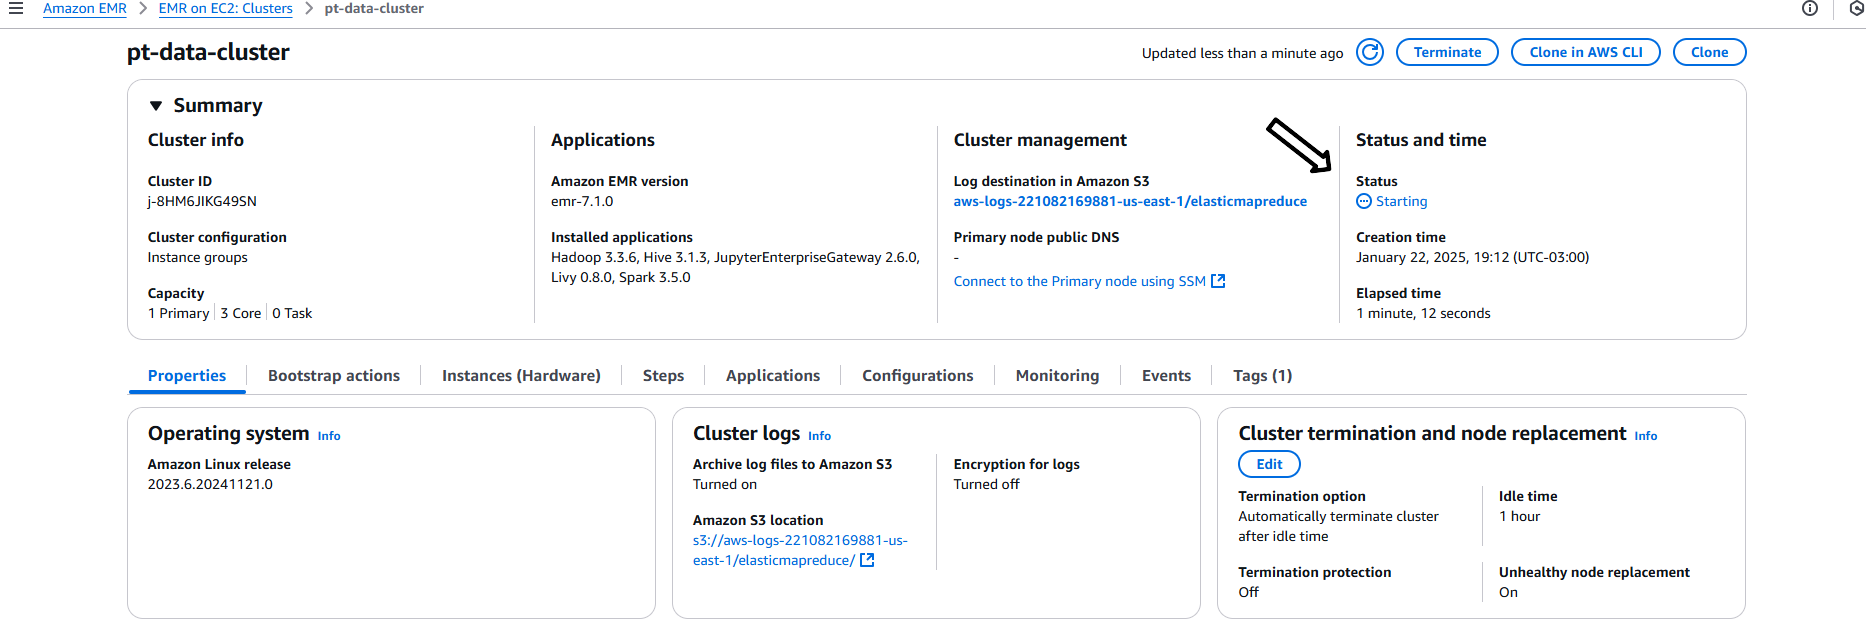



### 4° Segue abaixo o código para a criação da aplicação

In [ ]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Criação da SparkSession

spark = SparkSession \
    .builder \
    .appName("job-cloud") \
    .getOrCreate()


# Configurando o nível de logging
spark.sparkContext.setLogLevel("ERROR")

# Lendo os dados do Data Lake
df = spark.read.format("csv") \
    .option("header", "True") \
    .option("inferSchema", "True") \
    .csv("s3a://landing-zo/*.csv")

# Imprimindo os dados lidos da raw
print("\nImprime os dados lidos da landing:")
df.show()

# Imprimindo o schema do dataframe
print("\nImprime o schema do dataframe lido da raw:")
df.printSchema()

# Convertendo para formato parquet
print("\nEscrevendo os dados lidos da raw para parquet na processing zone...")
df.write.format("parquet") \
    .mode("overwrite") \
    .save("s3a://processing-zo/df-parquet-file.parquet")

# Lendo arquivos parquet
df_parquet = spark.read.format("parquet") \
    .load("s3a://processing-zo/df-parquet-file.parquet")

# Imprimindo os dados lidos em parquet
print("\nImprime os dados lidos em parquet da processing zone")
df_parquet.show()

# Criando uma view para trabalhar com SQL
df_parquet.createOrReplaceTempView("view_df_parquet")

# Processando os dados conforme regra de negócio
df_result = spark.sql("""
    SELECT 
        BNF_CODE AS Bnf_code,
        SUM(ACT_COST) AS Soma_Act_cost,
        SUM(QUANTITY) AS Soma_Quantity,
        SUM(ITEMS) AS Soma_items,
        AVG(ACT_COST) AS Media_Act_cost
    FROM view_df_parquet
    GROUP BY BNF_CODE
""")

# Imprimindo o resultado do dataframe criado
print("\n========= Imprime o resultado do dataframe processado =========\n")
df_result.show()

# Convertendo os dados processados para parquet e escrevendo na curated zone
print("\nEscrevendo os dados processados na Curated Zone...")
df_result.write.format("parquet") \
    .mode("overwrite") \
    .save("s3a://curated-zo/df-result-file.parquet")

# Finalizando a aplicação
spark.stop()


### 5° Agora iniciaremos o processo de criação de uma **Step Functions** 
#### Step Functions: Servirá para a automação do nosso ETL
- Crio uma pasta chamada App dentro do bucket Landing-zo para ser alocado a nossa aplicação Spark.


### Criando uma step
- **Step setting:** Escolho uma Spark applicattion.
- **Name:** job-star.
- **Deploy mode:**  Coloco a opção **Client mode** que é voltada para testes e desenvolvimento.
- **Aplicattion location:** Passo o caminho onde se encontra a aplicação Spark.
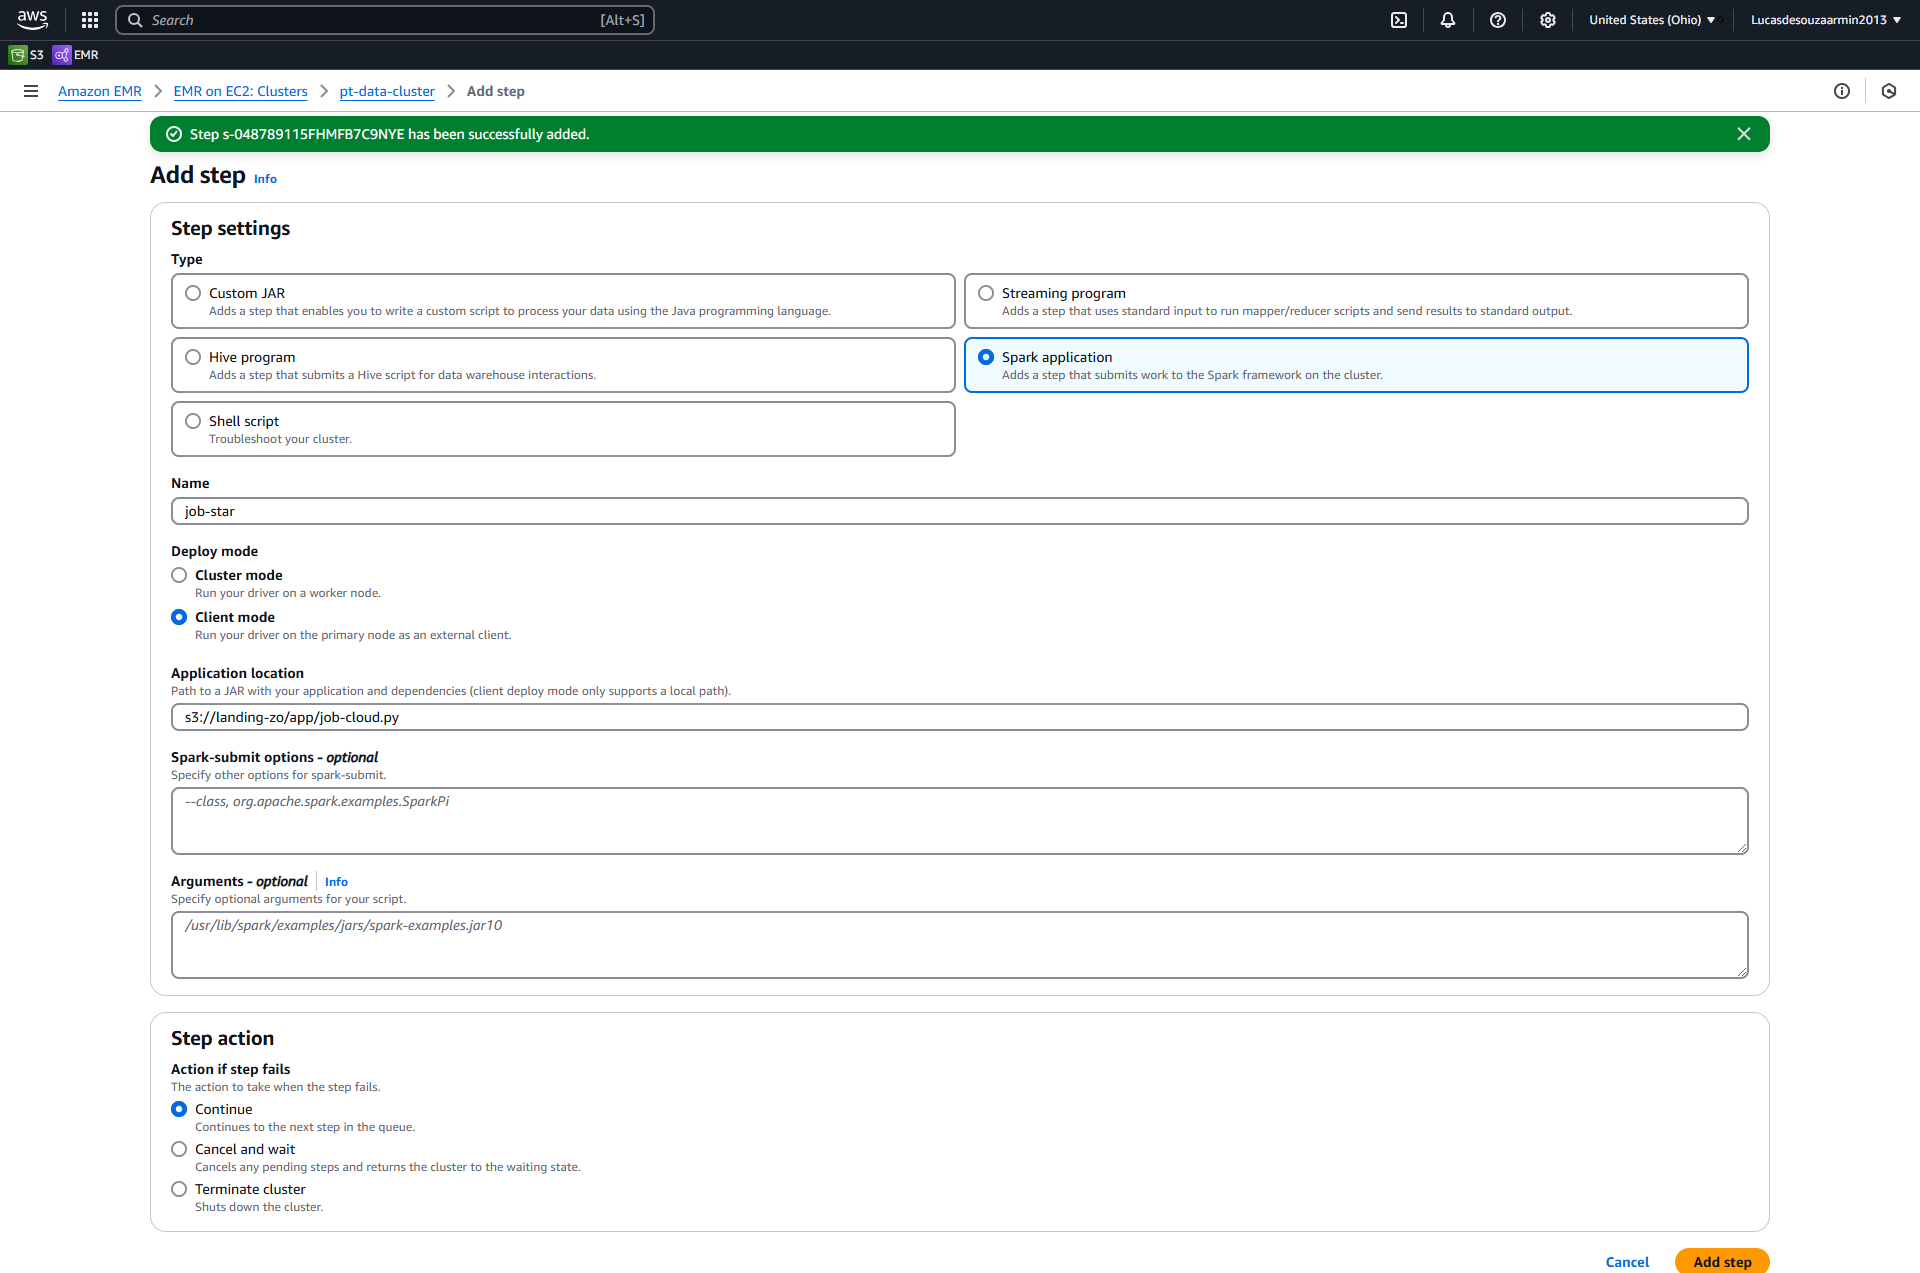


### Step em execução
- **Log files:** Em stdout já conseguimos verificar a primeira saída da nossa aplicação


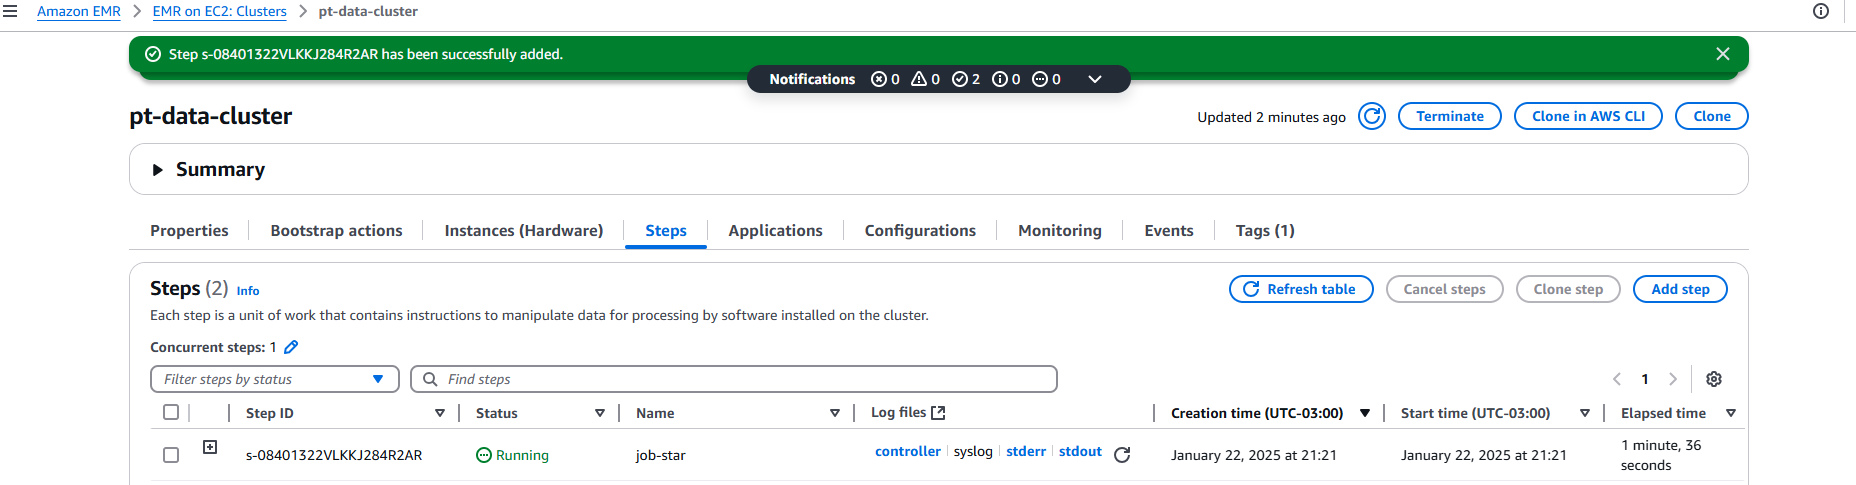







### Saída
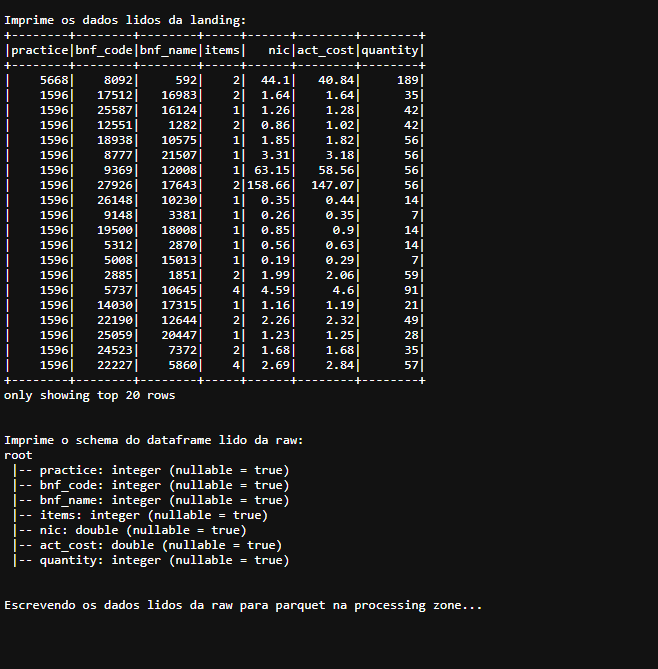




### Step concluída com sucesso
- #### Caso o job tivesse alguma falha, iria mostrar em Status.
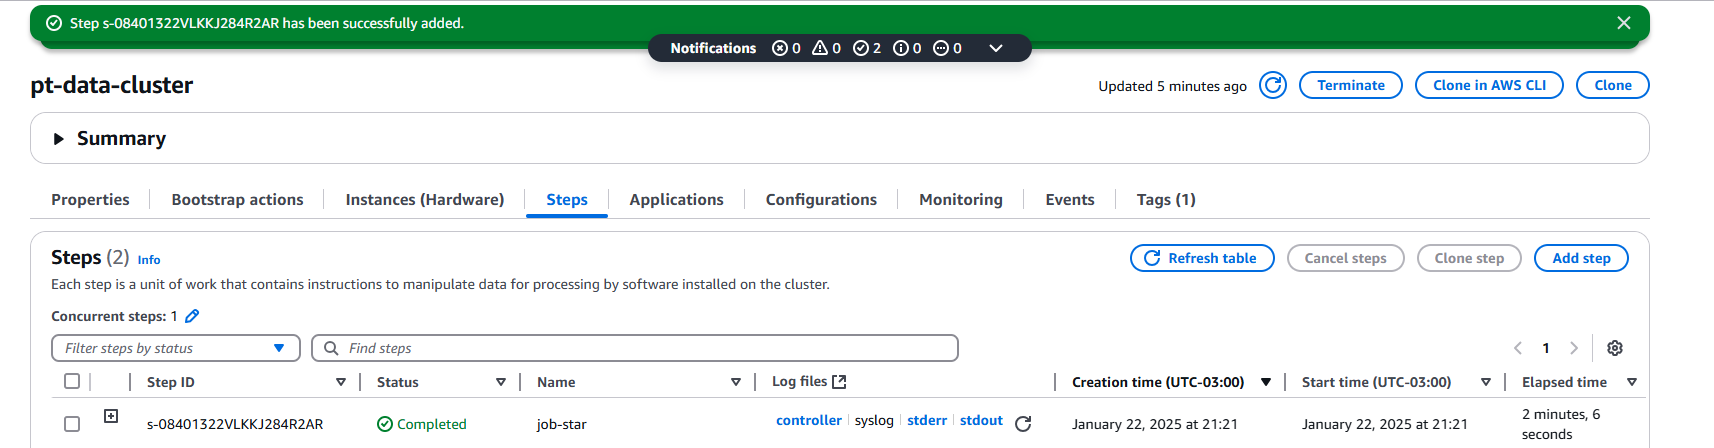

### 6° Verificado os resultados dentro do datalake

#### Processing zone

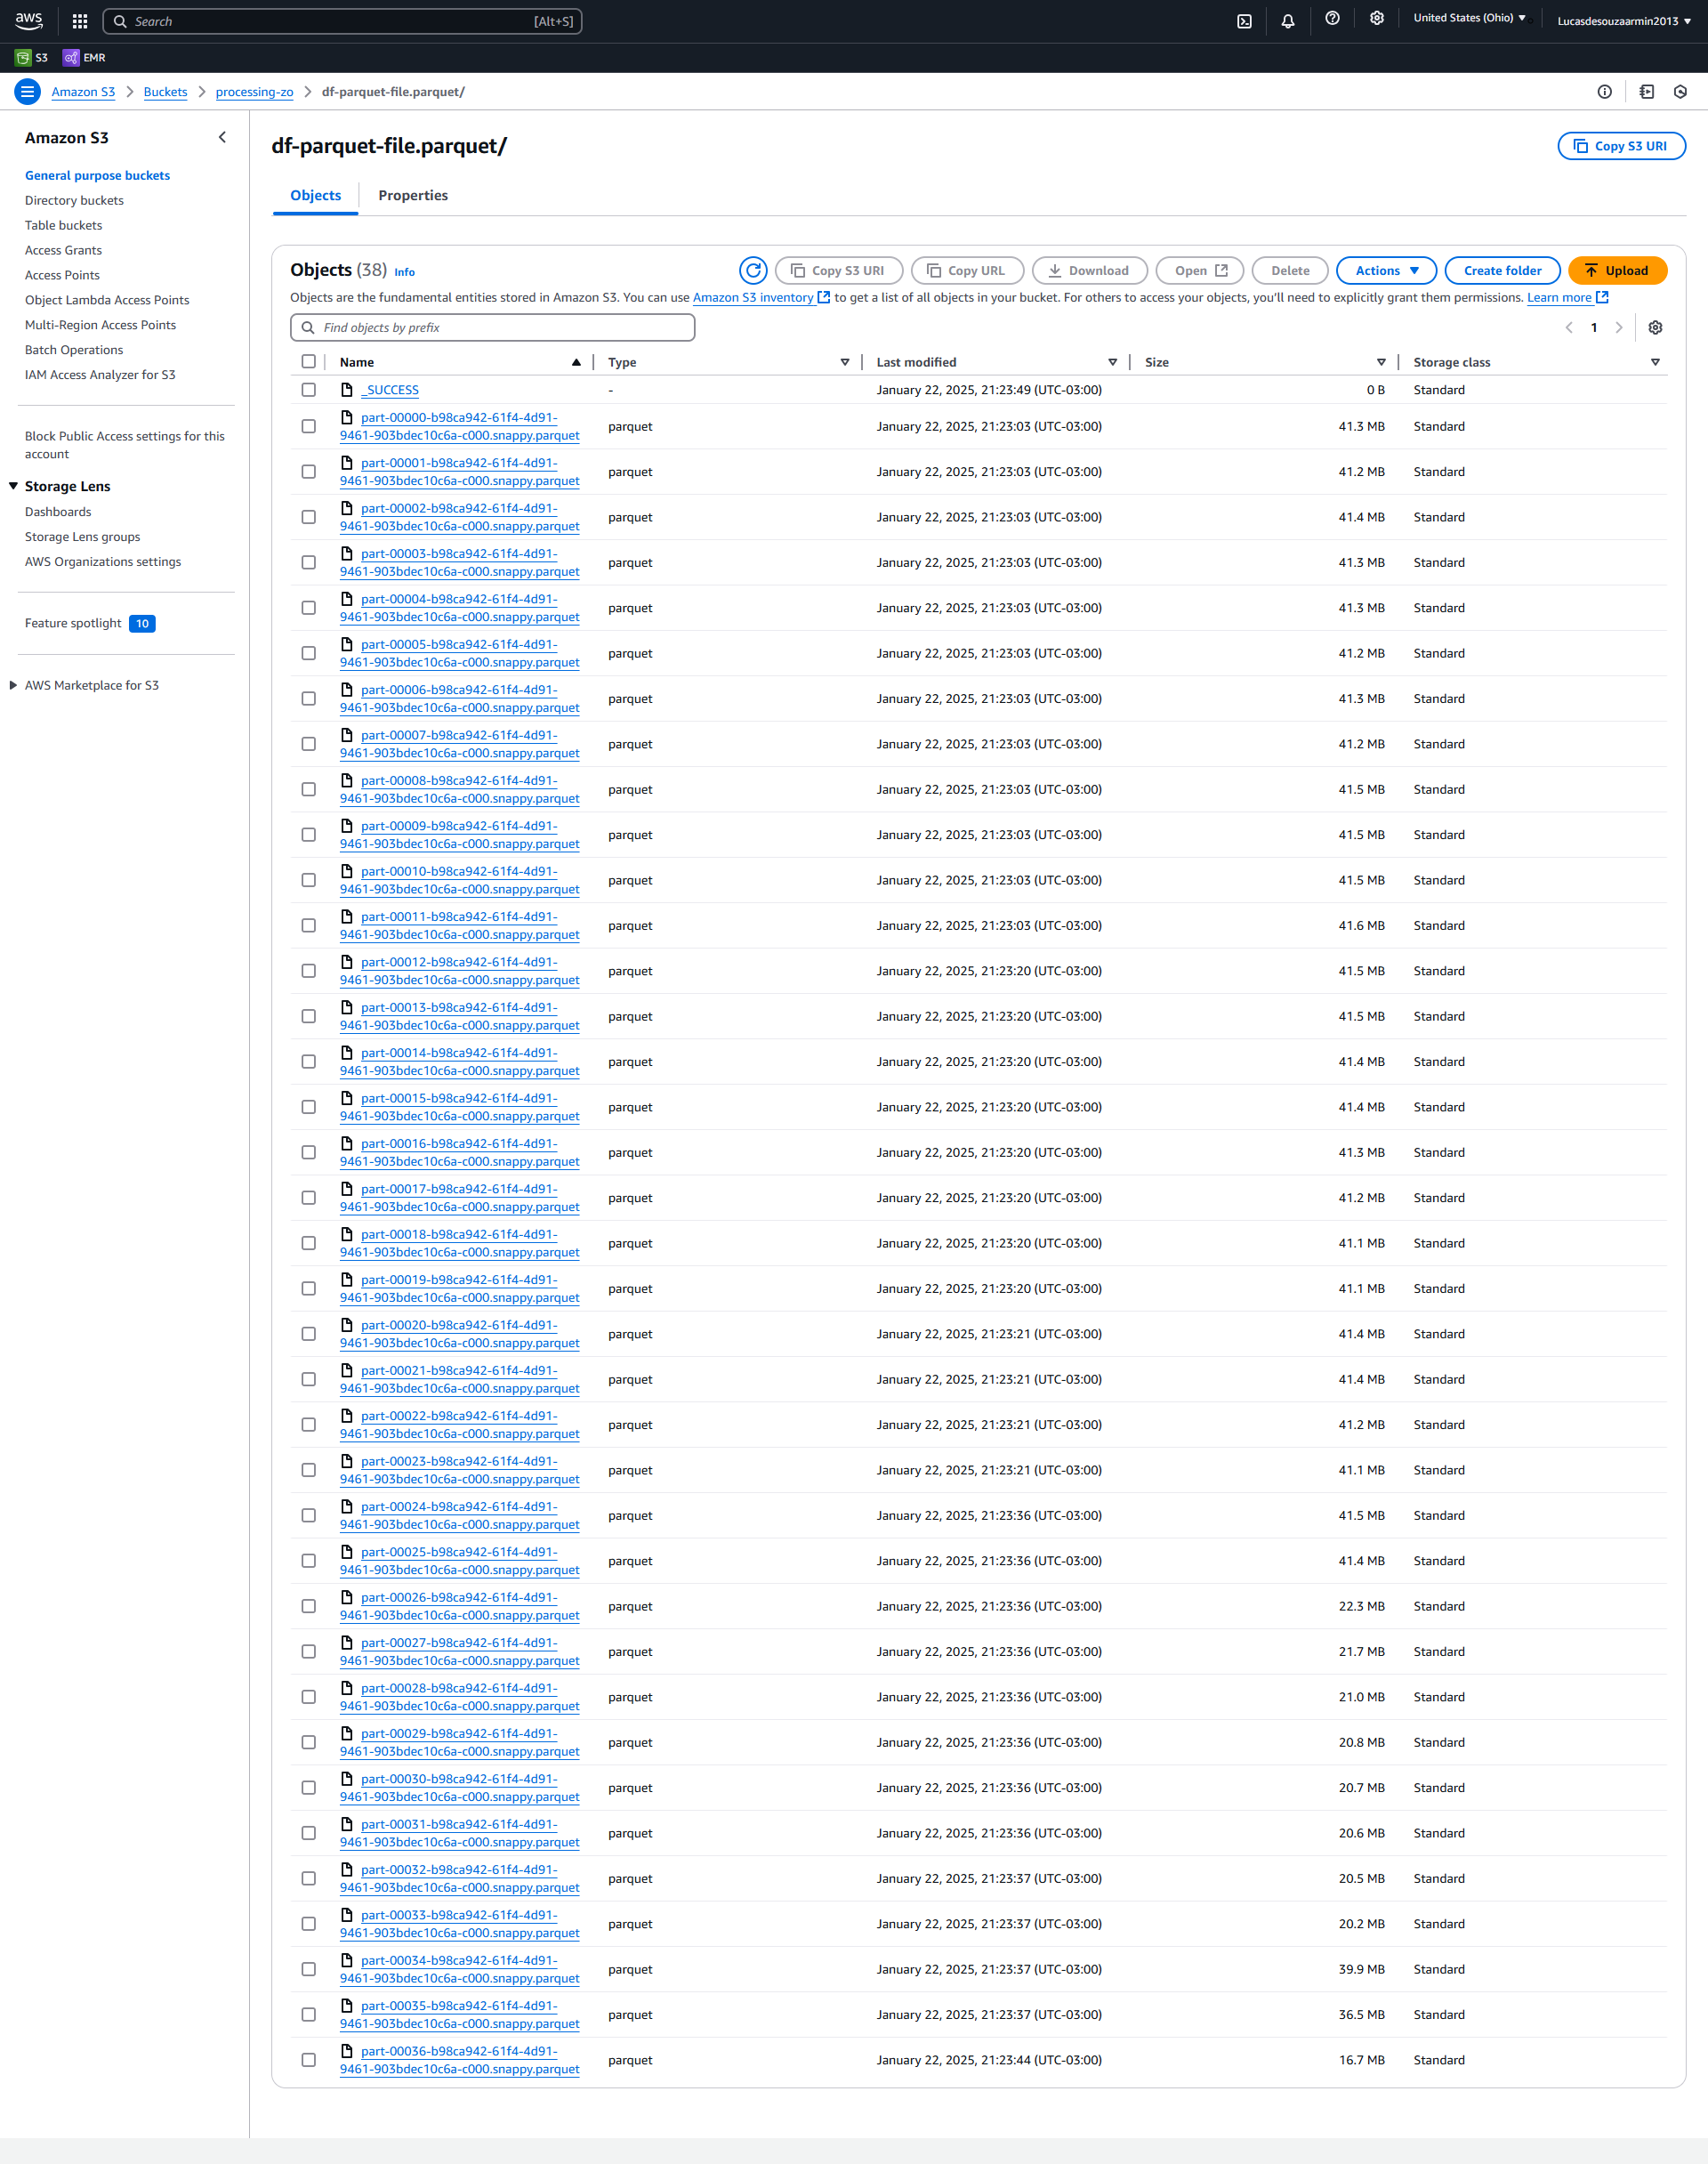

#### Curated zone

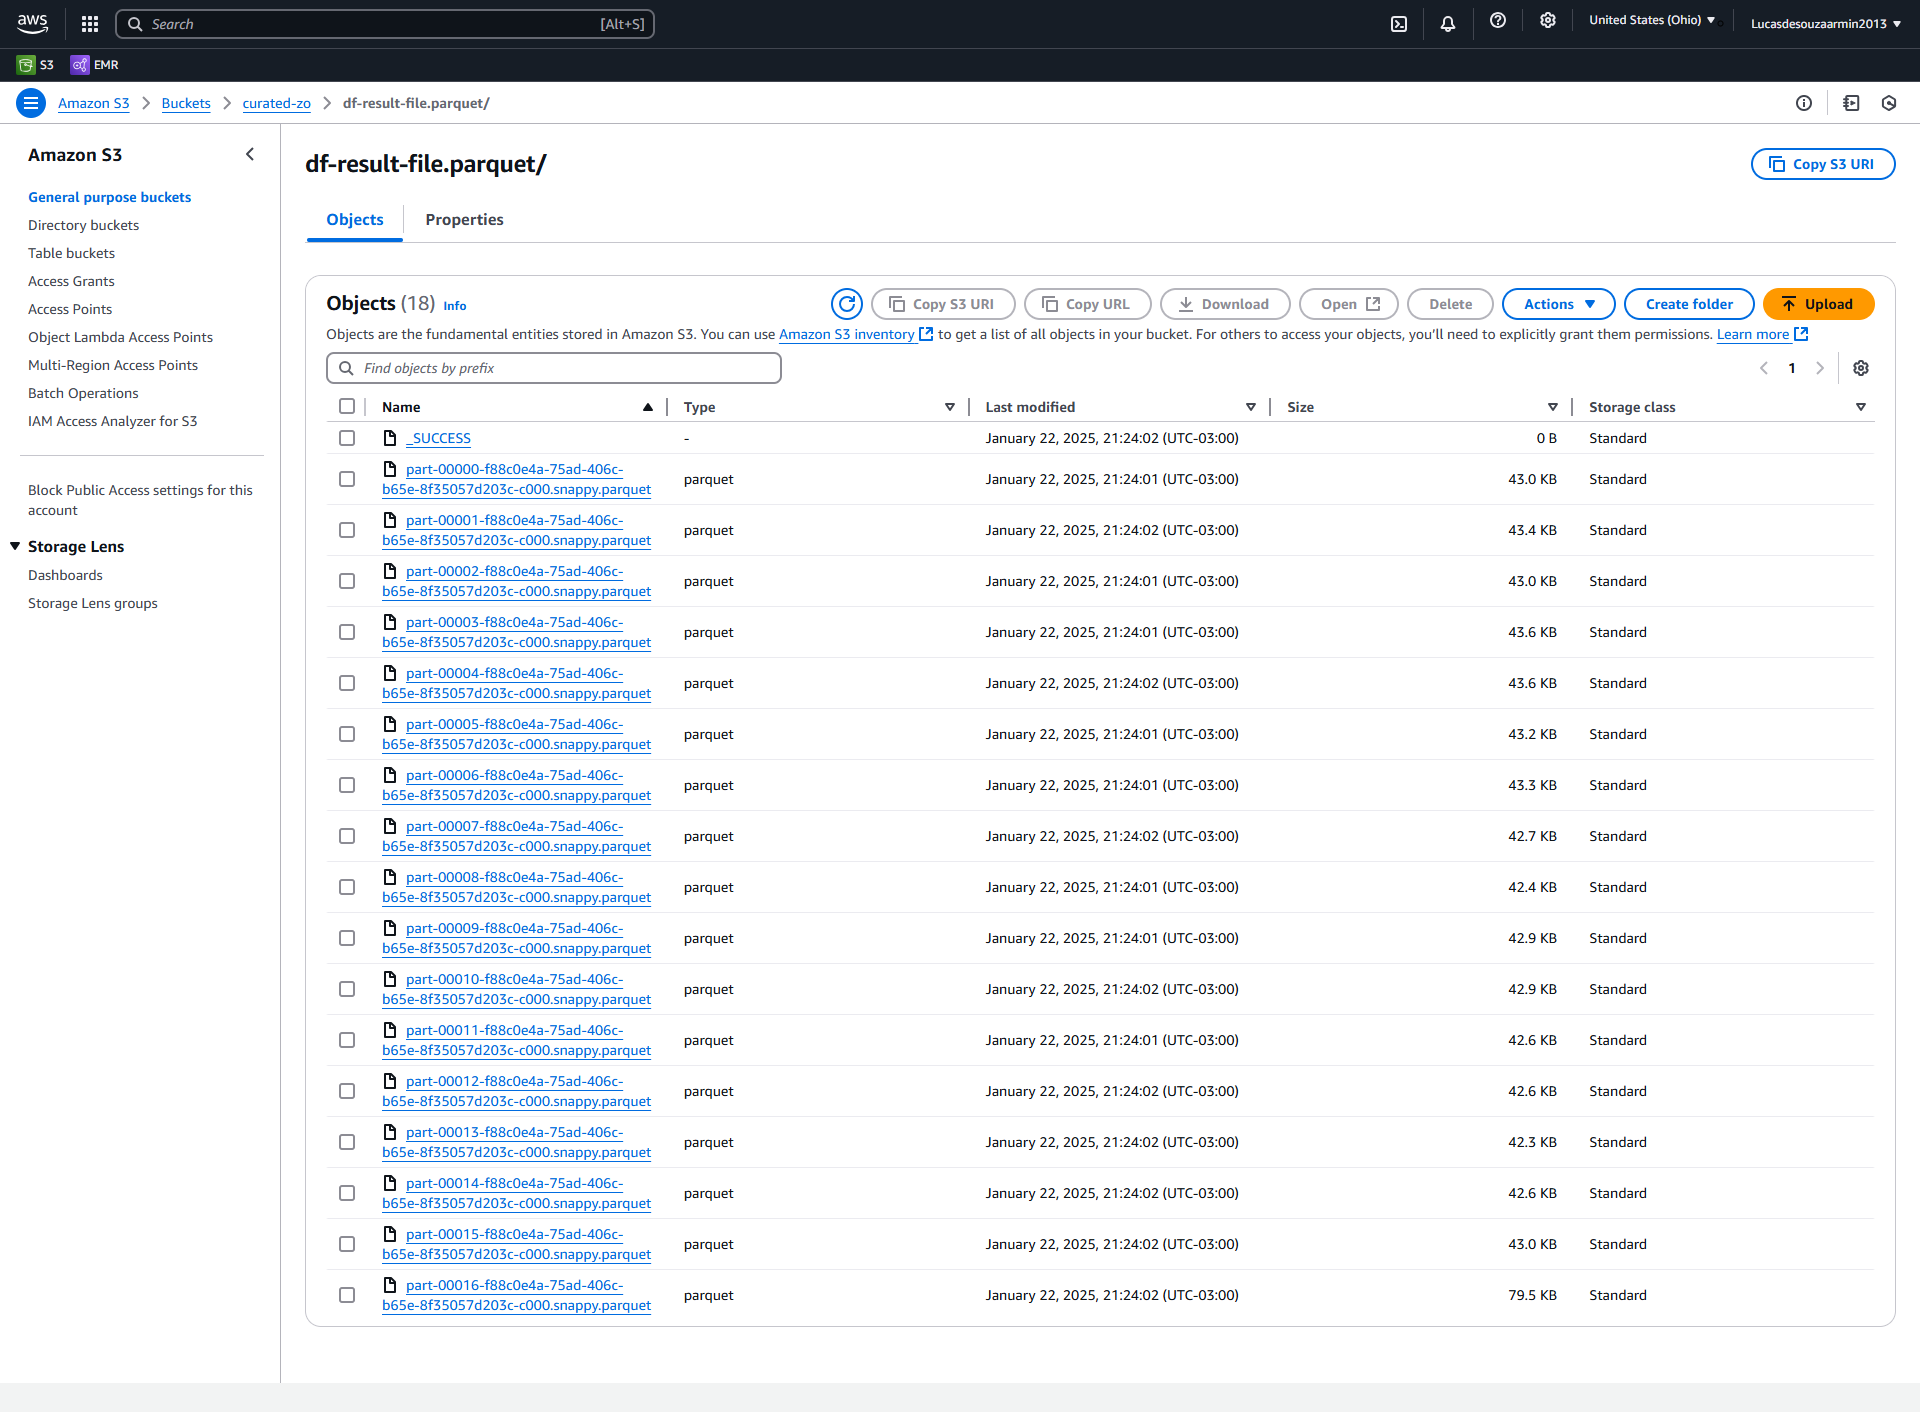

### 7° Monitorando a aplicação com  Spark history server
#### O Spark History Server permite visualizar informações detalhadas sobre jobs, stages e tasks que foram executados em um cluster Spark.

#### **Interface web**
- Já temos algumas infomações: **Nome,** **Inicio,** **Termino**, **Duração** da aplicação.
- Seleciono App ID.


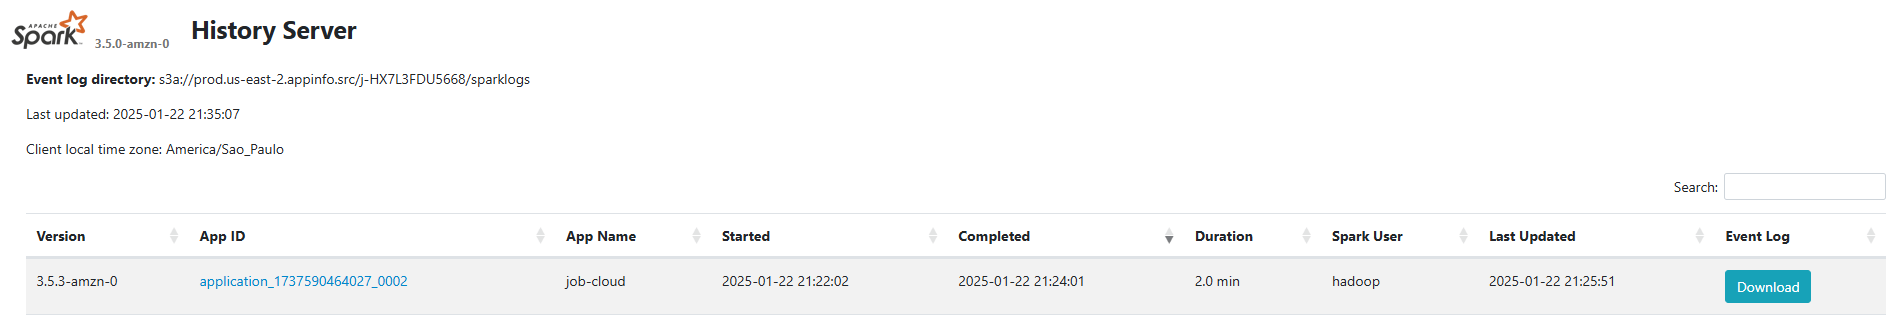


#### **Jobs**
- **Mostra todos os jobs submetidos**.
- **Exibe os status**.
- **Usado para acompanhar o progresso geral da papiline**.




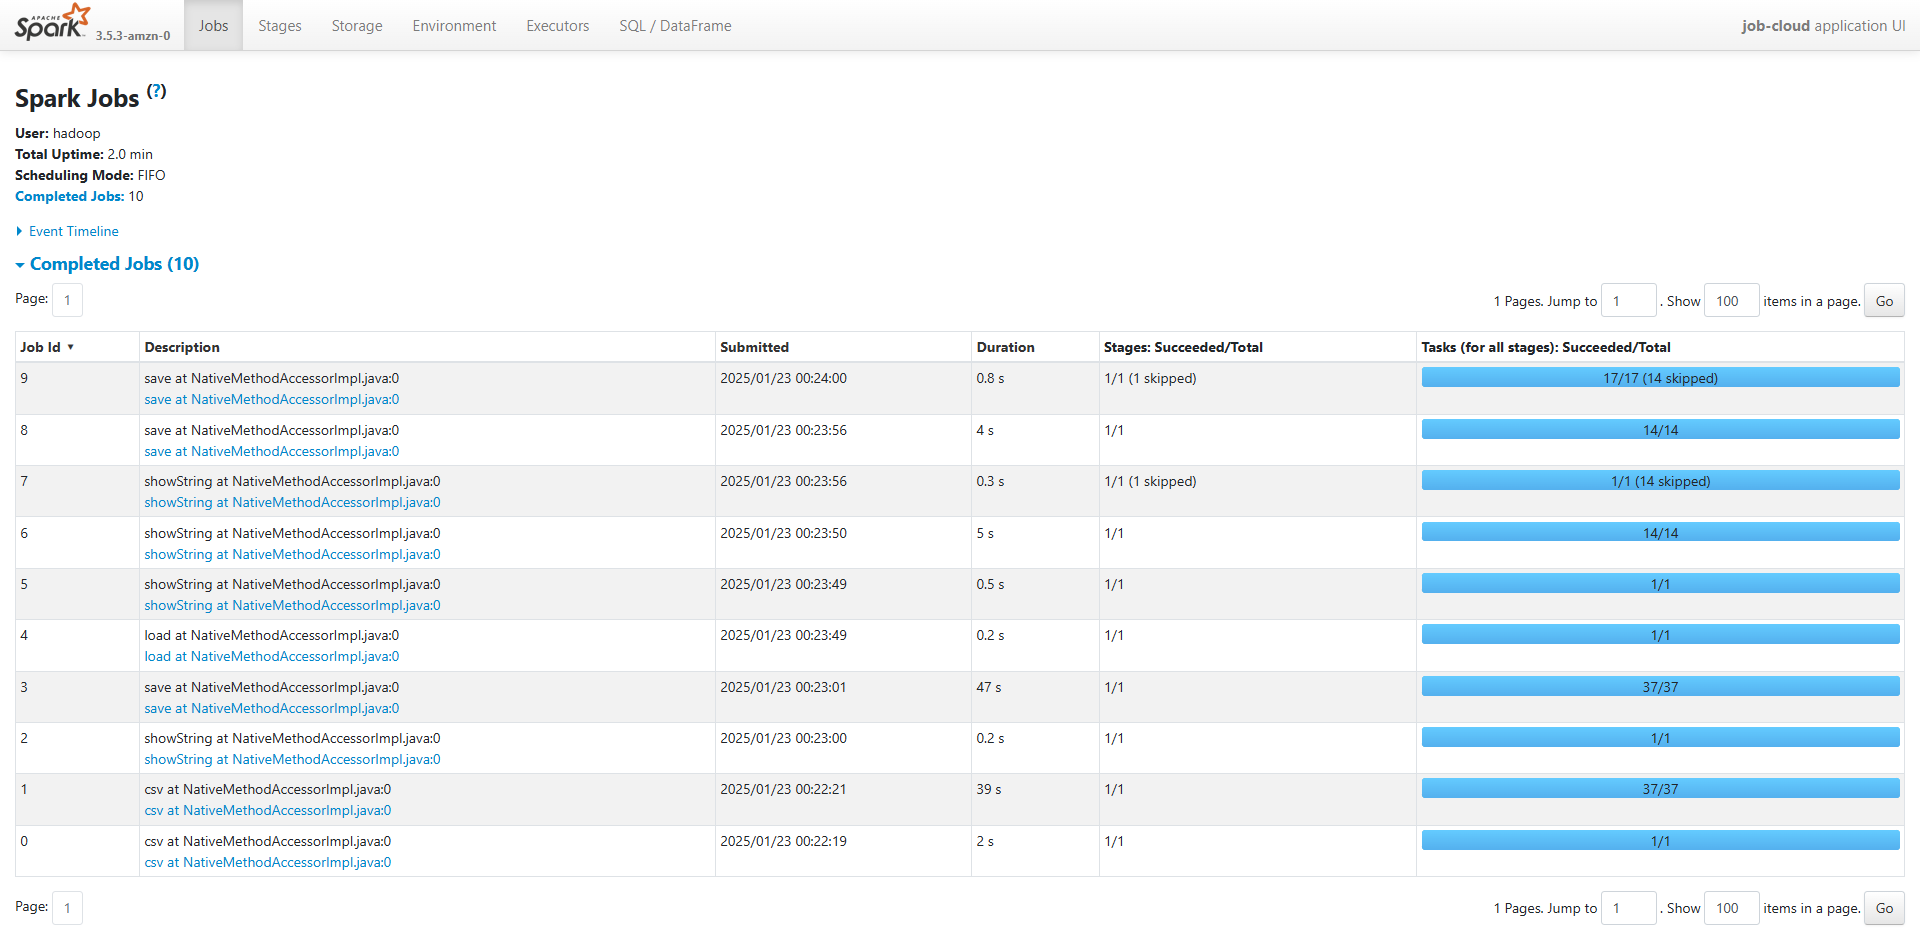

#### **Time Line Jobs**


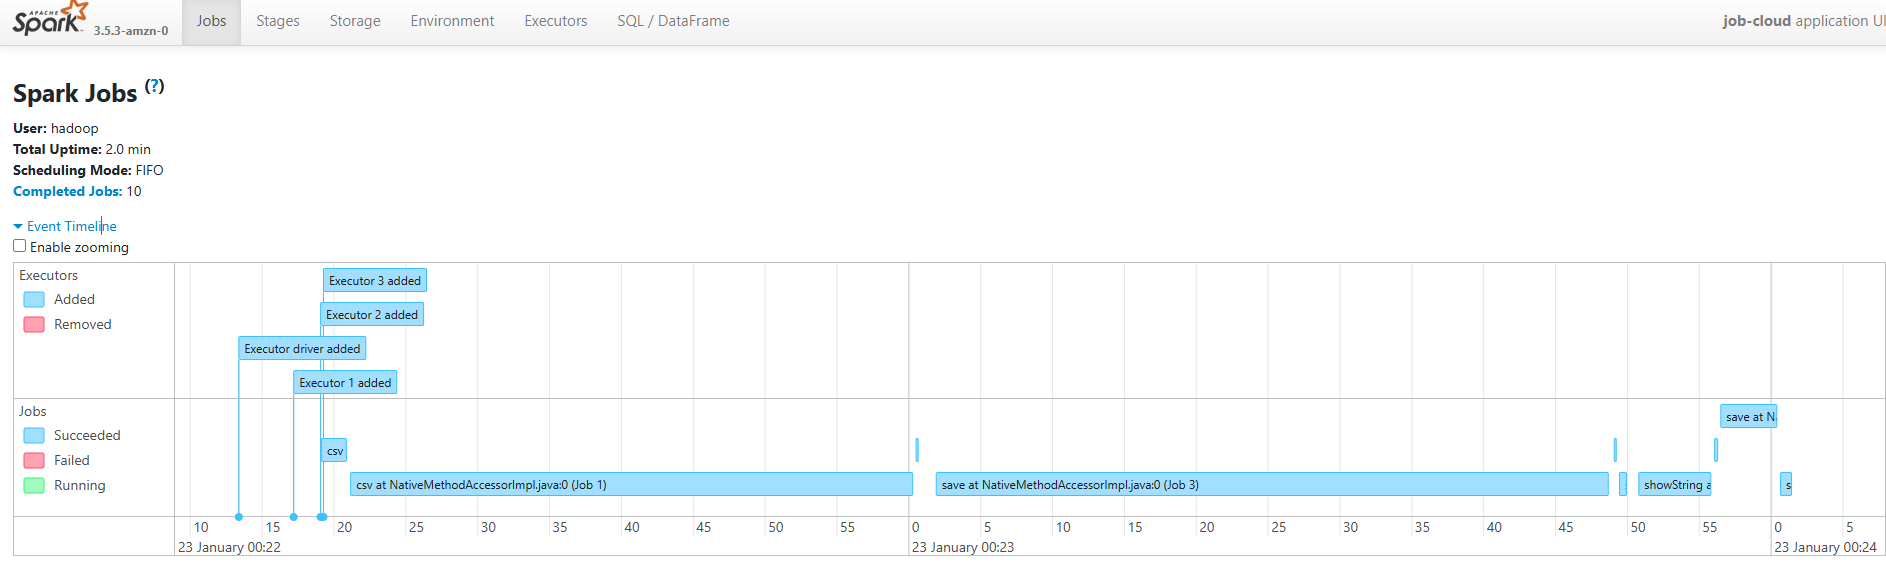

#### **Stages**
- **Divide os Jobs em Stages, que são conjuntos de tarefas**.
- **Ajuda a identificar gargalos no processamento**.

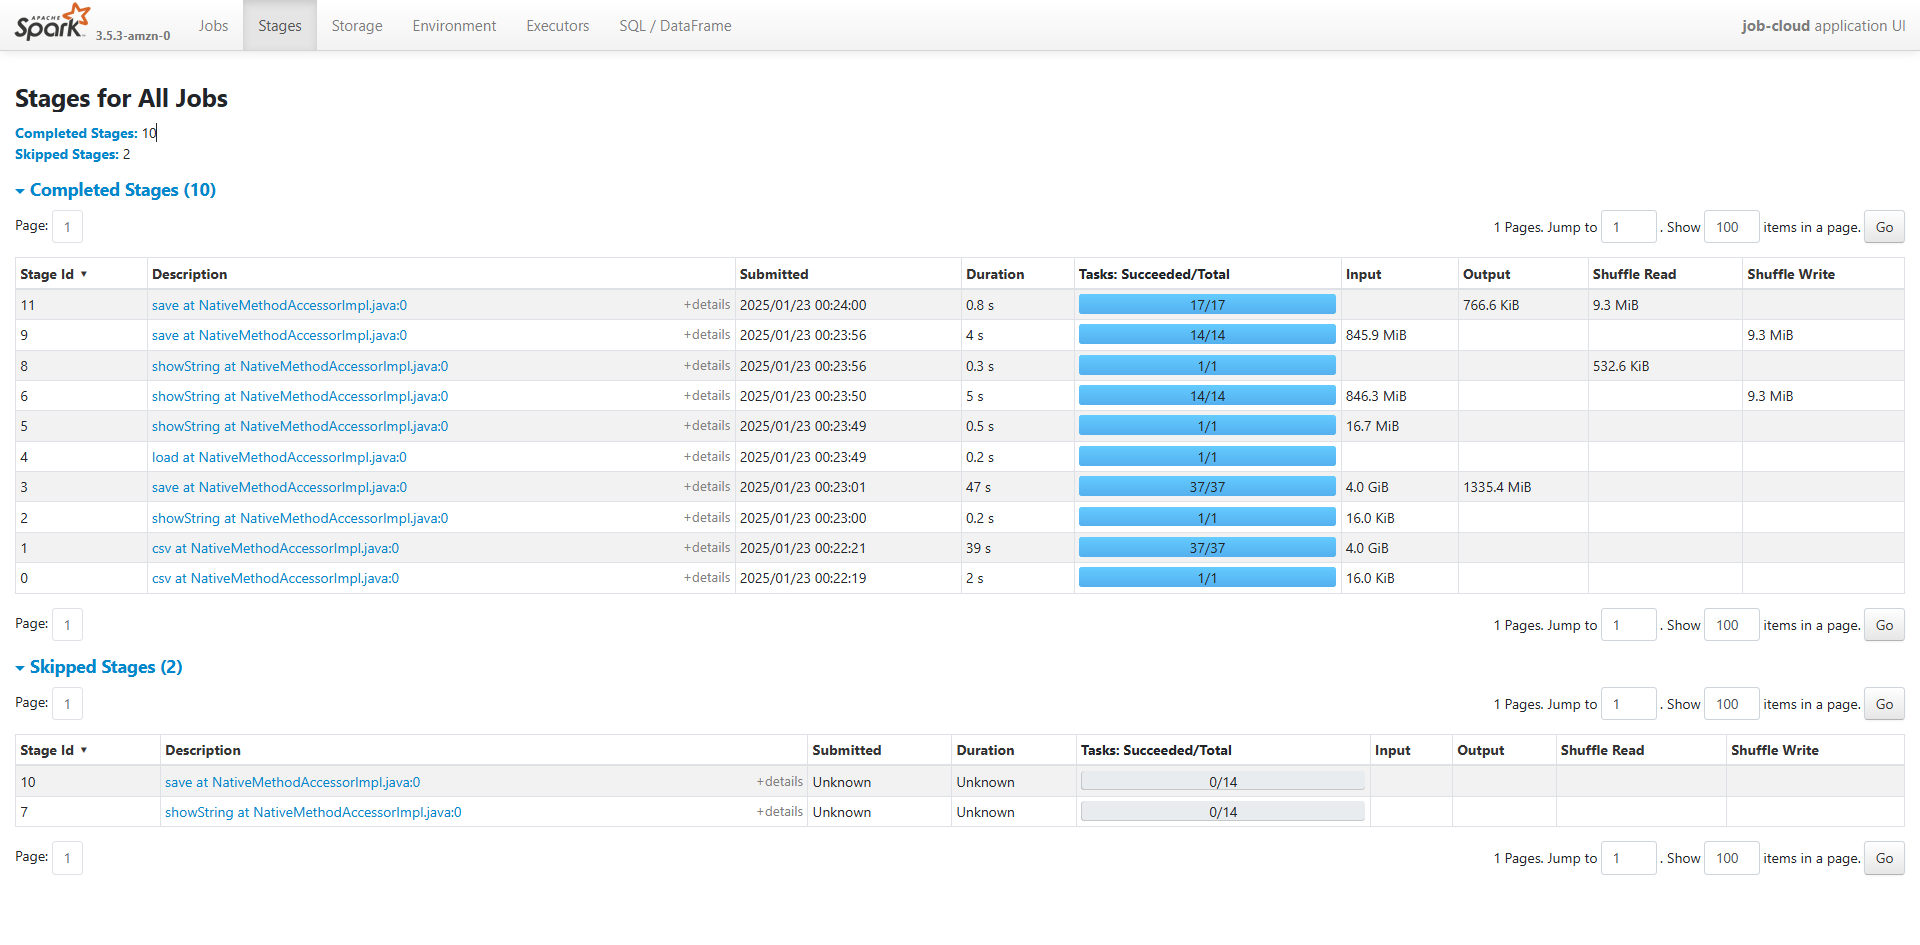

#### **Executors**
- **Mostra quantos executores estão ativos, consumo de CPU, memória e tempo de execução**.


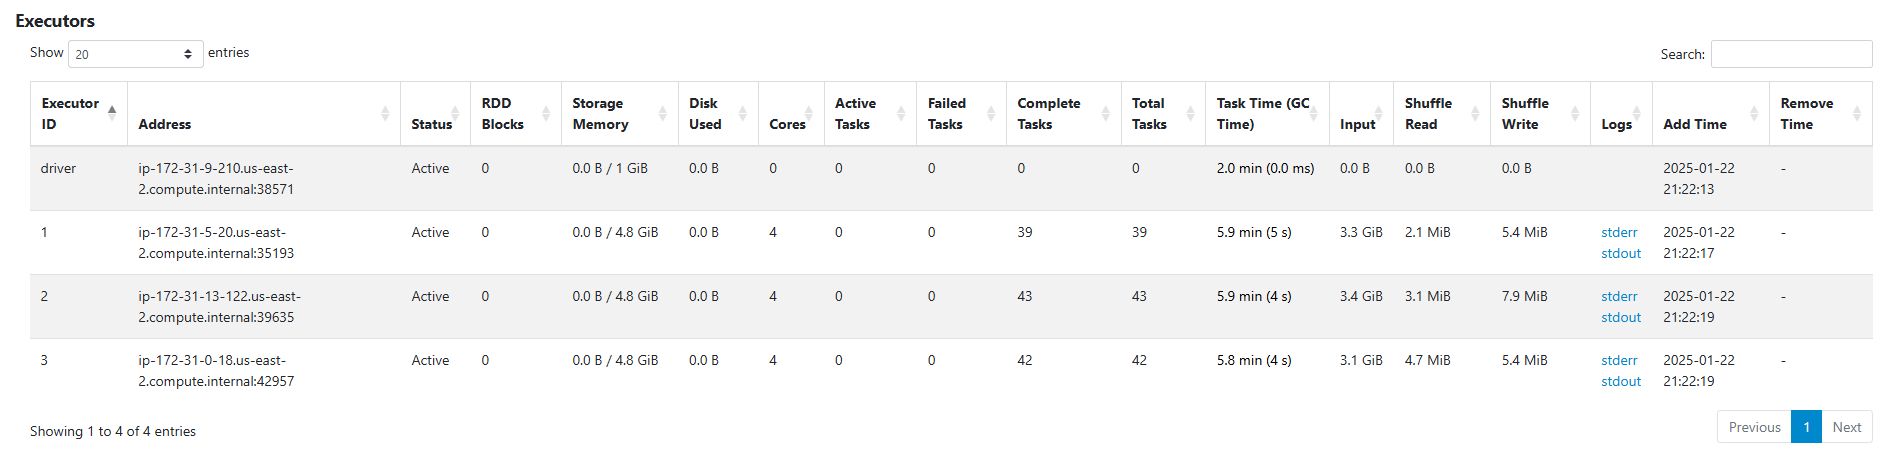

# Conclusão

## 📂 Arquitetura de 3 Camadas (Landing, Processing e Curated)
### 📌 O que foi feito?

Os dados são armazenados de forma organizada em três camadas:
Landing Zone: recebe os dados brutos sem transformações.
Processing Zone: onde ocorrem as transformações e limpeza dos dados.
Curated Zone: onde os dados tratados ficam prontos para consumo em relatórios e análises.

### 🎯 Por que vale a pena?

Organização e governança dos dados: evita que dados corrompidos ou errados cheguem na análise.
Facilidade na auditoria e reprocessamento: se houver erro na transformação, basta refazer a partir da camada anterior.
Escalabilidade: permite expandir o pipeline sem comprometer a estrutura.

## ☁️ Uso do Amazon S3 para Data Lake
### 📌 O que foi feito?

Os dados foram armazenados no Amazon S3, criando uma arquitetura flexível e econômica.

### 🎯 Por que vale a pena?

Baixo custo: S3 é mais barato do que armazenar em bancos de dados relacionais.
Escalabilidade infinita: permite lidar com grandes volumes de dados sem precisar se preocupar com capacidade de armazenamento.
Compatibilidade com diversos formatos: aceita CSV, JSON, Parquet, ORC, Avro, etc.

## 🚀 Processamento Distribuído com Apache Spark no EMR
### 📌 O que foi feito?

Criado um cluster Amazon EMR para processar os dados com PySpark.
O Spark lê os dados brutos da Landing Zone, realiza transformações e grava os resultados na Processing e Curated Zone.

### 🎯 Por que vale a pena?

Alta performance: Spark processa terabytes de dados de forma paralela.
Escalabilidade dinâmica: podemos aumentar ou reduzir o número de nós do cluster conforme a demanda.
Custo sob demanda: em vez de pagar por uma infraestrutura sempre ativa, o cluster pode ser desligado após o processamento.
## ⚙️ Automação com AWS Step Functions
### 📌 O que foi feito?

Criada uma Step Function para executar o pipeline automaticamente.

### 🎯 Por que vale a pena?

Redução de erros manuais: evita a necessidade de rodar o pipeline manualmente.
Orquestração eficiente: garante que cada etapa (ingestão, transformação, gravação) ocorra na sequência correta.
Monitoramento simplificado: facilita a identificação de falhas e o reprocessamento de etapas específicas.


## 📉 Monitoramento com Spark History Server

### 📌 O que foi feito?

O Spark History Server foi ativado para visualizar logs e métricas de execução dos jobs.

### 🎯 Por que vale a pena?

permite ver quais tarefas falharam e por quê.
Análise de performance: ajuda a otimizar o uso de memória e CPU do cluster.



## Por que essa solução é eficiente?
 -  **Escalável:** Pode lidar com grandes volumes de dados sem impacto no desempenho.
-  **Econômica:** Usa recursos sob demanda, evitando gastos desnecessários.
-  **Automatizada:** Menos intervenção manual, mais confiabilidade no processamento.
-  **Organizada:** Segue boas práticas de Data Lake e processamento distribuído.
-  **Monitorável:** Garante que erros sejam identificados rapidamente para ajustes.

